In [10]:
"""
PLAsTiCC_in_a_kernel_meta_and_data
----------------------------------
@website https://www.kaggle.com/ogrellier/plasticc-in-a-kernel-meta-and-data

@author Olivier https://www.kaggle.com/ogrellier

Goal :
------
Train 5 lightgbms on the meta_data + aggregated data

Then go through test data in chunks and generate predictions

New in this version :
---------------------
1. This versions adds some of the Flux calculations made available by MichaelApers https://www.kaggle.com/michaelapers
    here https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit
2. class 99 mean adjustment

"""

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import logging


def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def predict_chunk(df_, clfs_, meta_, features, train_mean):

    df_['flux_ratio_sq'] = np.power(df_['flux'] / df_['flux_err'], 2.0)
    df_['flux_by_flux_ratio_sq'] = df_['flux'] * df_['flux_ratio_sq']

    # Group by object id
    aggs = get_aggregations()

    aggs = get_aggregations()
    aggs['flux_ratio_sq'] = ['sum']
    aggs['flux_by_flux_ratio_sq'] = ['sum']

    new_columns = get_new_columns(aggs)

    agg_ = df_.groupby('object_id').agg(aggs)
    agg_.columns = new_columns

    agg_ = add_features_to_agg(df=agg_)

    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )

    full_test = full_test.fillna(train_mean)
    
    # 增加 mean_flux_per_band
    # band = df_.groupby(['object_id','passband'])['flux'].mean().unstack()
    # band['object_id'] = band.index
    # band.reset_index(drop=True, inplace=True)
    # full_test = full_test.merge(band, on='object_id', how='left').fillna(0)
    
    full_test = add_band_feats(full_test, df_)
    # 增加 mean_flux_per_band
    
    
    
    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

    print(preds_df_['class_99'].mean())

    del agg_, full_test, preds_
    gc.collect()

    return preds_df_


def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig('importances.png')


def train_classifiers(full_train=None, y=None):

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03,
        'subsample': .9,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01,
        'min_child_weight': 10,
        'n_estimators': 1000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3
    }
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)

    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

    return clfs, importances


def get_aggregations():
    return {
        'mjd': ['min', 'max', 'size'],
        'passband': ['mean', 'std', 'var'],  # ''min', 'max', 'mean', 'median', 'std'],
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std'],
        'detected': ['mean'],  # ''min', 'max', 'mean', 'median', 'std'],
    }


def get_new_columns(aggs):
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]


def add_features_to_agg(df):
    df['mjd_diff'] = df['mjd_max'] - df['mjd_min']
    df['flux_diff'] = df['flux_max'] - df['flux_min']
    df['flux_dif2'] = (df['flux_max'] - df['flux_min']) / df['flux_mean']
    df['flux_w_mean'] = df['flux_by_flux_ratio_sq_sum'] / df['flux_ratio_sq_sum']
    df['flux_dif3'] = (df['flux_max'] - df['flux_min']) / df['flux_w_mean']

    del df['mjd_max'], df['mjd_min']

    return df
    

def add_band_feats(df, db):
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    
    
    
    
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    
    
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    
    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 


    
    return df



def main():
    train = pd.read_csv('../data/training_set.csv')
    train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
    train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

    # train = pd.concat([train, pd.get_dummies(train['passband'], prefix='passband')], axis=1, sort=False)

    aggs = get_aggregations()
    aggs['flux_ratio_sq'] = ['sum']
    aggs['flux_by_flux_ratio_sq'] = ['sum']

    # passbands = [f for f in train if 'passband_' in f]
    # get_logger().info('Passband features : {}'.format(passbands))
    # for pb in passbands:
    #     aggs[pb] = ['mean']

    agg_train = train.groupby('object_id').agg(aggs)
    new_columns = get_new_columns(aggs)
    agg_train.columns = new_columns

    agg_train = add_features_to_agg(df=agg_train)
    
    agg_train.head()

    # del train
    # gc.collect()

    meta_train = pd.read_csv('../data/training_set_metadata.csv')
    meta_train.head()

    full_train = agg_train.reset_index().merge(
        right=meta_train,
        how='outer',
        on='object_id'
    )

    y = full_train['target']
    del full_train['target']
    # del full_train['object_id'], full_train['hostgal_specz']  # , full_train['distmod']
    del full_train['hostgal_specz']  # , full_train['distmod']

    train_mean = full_train.mean(axis=0)
    full_train.fillna(train_mean, inplace=True)
    
    
    # 增加 mean_flux_per_band
    # band = train.groupby(['object_id','passband'])['flux'].mean().unstack()
    # band['object_id'] = band.index
    # band.reset_index(drop=True, inplace=True)
    # full_train = full_train.merge(band, on='object_id', how='left').fillna(0)
    full_train = add_band_feats(full_train, train)
    
    
    # 增加 mean_flux_per_band
    
    del full_train['object_id']
    del train
    gc.collect()

    
    
    
    
    get_logger().info(full_train.columns)
    clfs, importances = train_classifiers(full_train, y)

    save_importances(importances_=importances)

    meta_test = pd.read_csv(r'../data/test_set_metadata.csv')

    import time

    start = time.time()
    # chunks = 5000000
    chunks = 500000
    remain_df = None

    # for i_c, df in enumerate(pd.read_csv('../input/test_set.csv', chunksize=chunks, iterator=True)):
    for i_c, df in enumerate(pd.read_csv(r'../data/test_set_sample.csv', chunksize=chunks, iterator=True)):
        # Check object_ids
        # I believe np.unique keeps the order of group_ids as they appear in the file
        unique_ids = np.unique(df['object_id'])
        new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()

        if remain_df is None:
            df = df.loc[df['object_id'].isin(unique_ids[:-1])].copy()
        else:
            df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)

        # Create remaining samples df
        remain_df = new_remain_df

        preds_df = predict_chunk(df_=df,
                                 clfs_=clfs,
                                 meta_=meta_test,
                                 features=full_train.columns,
                                 train_mean=train_mean)

        if i_c == 0:
            preds_df.to_csv(r'predictions_v3.csv', header=True, index=False, float_format='%.6f')
        else:
            preds_df.to_csv(r'predictions_v3.csv', header=False, mode='a', index=False, float_format='%.6f')

        del preds_df
        gc.collect()
######################################################
#         if (i_c + 1) % 10 == 0:
        if (i_c + 1) % 1 == 0:
            get_logger().info('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))
            get_logger().info('Progress percentage : %5.2f' % chunks * (i_c + 1)/500000000)
            get_logger().info('Time estimated left : %5.2f' % (time.time() - start) / 60 * (500000000-chunks * (i_c + 1))/chunks * (i_c + 1))
            print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))
            print('Progress percentage : %5.2f' % chunks * (i_c + 1)/500000000)
            print('Time estimated left : %5.2f' % (time.time() - start) / 60 * (500000000-chunks * (i_c + 1))/chunks * (i_c + 1))

    # Compute last object in remain_df

    preds_df = predict_chunk(df_=remain_df,
                             clfs_=clfs,
                             meta_=meta_test,
                             features=full_train.columns,
                             train_mean=train_mean)

    preds_df.to_csv(r'predictions_v3.csv', header=False, mode='a', index=False, float_format='%.6f')

    z = pd.read_csv(r'predictions_v3.csv')

    z = z.groupby('object_id').mean()
    
    z.to_csv(r'../result/single_predictions_v3.csv', index=True, float_format='%.6f')
    
    z['object_id'] = z.index
    
    z = z.drop_duplicates(subset=['object_id'], keep='first')

    z.to_csv(r'../result/single_predictions_v3.gz', index=False, float_format='%.6f', compression='gzip')
    
    





Adding feats for the flux mean per band...
Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_0_flux_mean', 'band_3_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_0_flux_mean', 'band_4_flux_mean_minus_band_1_flux_mean', 'band_4_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_0_flux_mean', 'band_5_flux_mean_minus_band_1_flux_mean', 'band_5_flux_mean_minus_band_2_flux_mean', 'band_5_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_4_flux_mean']
Adding feats for the flux std per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:290: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_std', 'band_1_flux_std', 'band_2_flux_std', 'band_3_flux_std', 'band_4_flux_std', 'band_5_flux_std']
Adding feats for the flux skew per band...
Feats added: ['band_0_flux_skew', 'band_1_flux_skew', 'band_2_flux_skew', 'band_3_flux_skew', 'band_4_flux_skew', 'band_5_flux_skew']
Adding feats for the flux max per band...
Feats added: ['band_0_flux_max', 'band_1_flux_max', 'band_2_flux_max', 'band_3_flux_max', 'band_4_flux_max', 'band_5_flux_max']
Adding feats for the flux min per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:297: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:304: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:312: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:320: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
[INFO]2018-10-25 15:00:04,309:main:Index(['mjd_size', 'passband_

Feats added: ['band_0_flux_min', 'band_1_flux_min', 'band_2_flux_min', 'band_3_flux_min', 'band_4_flux_min', 'band_5_flux_min']
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.823525	training's wloss: 1.0596	valid_1's multi_logloss: 0.898733	valid_1's wloss: 1.22061
[200]	training's multi_logloss: 0.609034	training's wloss: 0.78525	valid_1's multi_logloss: 0.735419	valid_1's wloss: 1.05173
[300]	training's multi_logloss: 0.517645	training's wloss: 0.640444	valid_1's multi_logloss: 0.69052	valid_1's wloss: 0.993453
[400]	training's multi_logloss: 0.46001	training's wloss: 0.547245	valid_1's multi_logloss: 0.67204	valid_1's wloss: 0.972207
Early stopping, best iteration is:
[449]	training's multi_logloss: 0.436889	training's wloss: 0.511304	valid_1's multi_logloss: 0.666175	valid_1's wloss: 0.967658


[INFO]2018-10-25 15:00:15,834:main:0.9676578759402553
[INFO]2018-10-25 15:00:15,834:main:0.9676578759402553
[INFO]2018-10-25 15:00:15,834:main:0.9676578759402553
[INFO]2018-10-25 15:00:15,834:main:0.9676578759402553


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.817399	training's wloss: 1.04696	valid_1's multi_logloss: 0.89761	valid_1's wloss: 1.25292
[200]	training's multi_logloss: 0.606458	training's wloss: 0.773267	valid_1's multi_logloss: 0.736718	valid_1's wloss: 1.08542
[300]	training's multi_logloss: 0.512045	training's wloss: 0.625455	valid_1's multi_logloss: 0.69307	valid_1's wloss: 1.0475
[400]	training's multi_logloss: 0.452664	training's wloss: 0.532681	valid_1's multi_logloss: 0.676607	valid_1's wloss: 1.03255
Early stopping, best iteration is:
[436]	training's multi_logloss: 0.435557	training's wloss: 0.50657	valid_1's multi_logloss: 0.672835	valid_1's wloss: 1.03096


[INFO]2018-10-25 15:00:27,130:main:1.0309564353568197
[INFO]2018-10-25 15:00:27,130:main:1.0309564353568197
[INFO]2018-10-25 15:00:27,130:main:1.0309564353568197
[INFO]2018-10-25 15:00:27,130:main:1.0309564353568197


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.818093	training's wloss: 1.05962	valid_1's multi_logloss: 0.905277	valid_1's wloss: 1.20984
[200]	training's multi_logloss: 0.606082	training's wloss: 0.781461	valid_1's multi_logloss: 0.743056	valid_1's wloss: 1.02217
[300]	training's multi_logloss: 0.512377	training's wloss: 0.631823	valid_1's multi_logloss: 0.696823	valid_1's wloss: 0.95913
[400]	training's multi_logloss: 0.454332	training's wloss: 0.538429	valid_1's multi_logloss: 0.679854	valid_1's wloss: 0.943606
Early stopping, best iteration is:
[444]	training's multi_logloss: 0.433233	training's wloss: 0.506754	valid_1's multi_logloss: 0.675295	valid_1's wloss: 0.941538


[INFO]2018-10-25 15:00:38,565:main:0.9415381591766968
[INFO]2018-10-25 15:00:38,565:main:0.9415381591766968
[INFO]2018-10-25 15:00:38,565:main:0.9415381591766968
[INFO]2018-10-25 15:00:38,565:main:0.9415381591766968


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.823842	training's wloss: 1.05661	valid_1's multi_logloss: 0.879306	valid_1's wloss: 1.17259
[200]	training's multi_logloss: 0.614396	training's wloss: 0.786026	valid_1's multi_logloss: 0.706745	valid_1's wloss: 1.0011
[300]	training's multi_logloss: 0.522533	training's wloss: 0.64349	valid_1's multi_logloss: 0.65914	valid_1's wloss: 0.950535
[400]	training's multi_logloss: 0.462261	training's wloss: 0.549488	valid_1's multi_logloss: 0.642333	valid_1's wloss: 0.936679
[500]	training's multi_logloss: 0.417568	training's wloss: 0.482107	valid_1's multi_logloss: 0.63495	valid_1's wloss: 0.93157
Early stopping, best iteration is:
[504]	training's multi_logloss: 0.41605	training's wloss: 0.47983	valid_1's multi_logloss: 0.63478	valid_1's wloss: 0.931067


[INFO]2018-10-25 15:00:51,319:main:0.9310668372780769
[INFO]2018-10-25 15:00:51,319:main:0.9310668372780769
[INFO]2018-10-25 15:00:51,319:main:0.9310668372780769
[INFO]2018-10-25 15:00:51,319:main:0.9310668372780769


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.821812	training's wloss: 1.05184	valid_1's multi_logloss: 0.899545	valid_1's wloss: 1.24647
[200]	training's multi_logloss: 0.606948	training's wloss: 0.775301	valid_1's multi_logloss: 0.736014	valid_1's wloss: 1.07395
[300]	training's multi_logloss: 0.514322	training's wloss: 0.629043	valid_1's multi_logloss: 0.690007	valid_1's wloss: 1.01026
[400]	training's multi_logloss: 0.455782	training's wloss: 0.536905	valid_1's multi_logloss: 0.672376	valid_1's wloss: 0.992679
[500]	training's multi_logloss: 0.411476	training's wloss: 0.470196	valid_1's multi_logloss: 0.664448	valid_1's wloss: 0.986649
Early stopping, best iteration is:
[503]	training's multi_logloss: 0.41038	training's wloss: 0.468563	valid_1's multi_logloss: 0.664332	valid_1's wloss: 0.986414


[INFO]2018-10-25 15:01:03,879:main:0.986413914619695
[INFO]2018-10-25 15:01:03,879:main:0.986413914619695
[INFO]2018-10-25 15:01:03,879:main:0.986413914619695
[INFO]2018-10-25 15:01:03,879:main:0.986413914619695
[INFO]2018-10-25 15:01:03,894:main:MULTI WEIGHTED LOG LOSS : 0.97157 
[INFO]2018-10-25 15:01:03,894:main:MULTI WEIGHTED LOG LOSS : 0.97157 
[INFO]2018-10-25 15:01:03,894:main:MULTI WEIGHTED LOG LOSS : 0.97157 
[INFO]2018-10-25 15:01:03,894:main:MULTI WEIGHTED LOG LOSS : 0.97157 
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Adding feats for the flux mean per band...
Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_0_flux_mean', 'band_3_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_0_flux_mean', 'band_4_flux_mean_minus_band_1_flux_mean', 'band_4_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_0_flux_mean', 'band_5_flux_mean_minus_band_1_flux_mean', 'band_5_flux_mean_minus_band_2_flux_mean', 'band_5_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_4_flux_mean']
Adding feats for the flux std per band...
Feats added: ['band_0_flux_std', 'band_1_flux_std', 'band_2_flux_std', 'band_3_flux_std', 'band_4_flux_std', 'band_5_flux_std']
Adding f

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:290: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:297: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_skew', 'band_1_flux_skew', 'band_2_flux_skew', 'band_3_flux_skew', 'band_4_flux_skew', 'band_5_flux_skew']
Adding feats for the flux max per band...
Feats added: ['band_0_flux_max', 'band_1_flux_max', 'band_2_flux_max', 'band_3_flux_max', 'band_4_flux_max', 'band_5_flux_max']
Adding feats for the flux min per band...
Feats added: ['band_0_flux_min', 'band_1_flux_min', 'band_2_flux_min', 'band_3_flux_min', 'band_4_flux_min', 'band_5_flux_min']


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:304: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:312: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:320: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
[INFO]2018-10-25 15:01:16,816:main:         500000 done in   0.1
[INFO]2018-10-25 15:01:16,816:main:         500000 done in   0.1
[INFO]2018-10-25 15:01:16,816:main:         500000 done in   0.1
[INFO]2018-10-25 15:01:16,816:main:         500000 done in   0.1
[INFO]2018-10-25 15:01:16,818:main:Pro

0.14
         500000 done in   0.1
Progress percentage : %5.2f 0.001
Time estimated left : %5.2f 83.25993211269379
Adding feats for the flux mean per band...
Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_0_flux_mean', 'band_3_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_0_flux_mean', 'band_4_flux_mean_minus_band_1_flux_mean', 'band_4_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_0_flux_mean', 'band_5_flux_mean_minus_band_1_flux_mean', 'band_5_flux_mean_minus_band_2_flux_mean', 'band_5_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_4_flux_mean']
Adding feats for the flux std per band...
Feats added: ['band_0

[INFO]2018-10-25 15:01:21,982:main:        1000000 done in   0.2
[INFO]2018-10-25 15:01:21,982:main:        1000000 done in   0.2
[INFO]2018-10-25 15:01:21,982:main:        1000000 done in   0.2
[INFO]2018-10-25 15:01:21,982:main:        1000000 done in   0.2
[INFO]2018-10-25 15:01:21,984:main:Progress percentage :  0.00
[INFO]2018-10-25 15:01:21,984:main:Progress percentage :  0.00
[INFO]2018-10-25 15:01:21,984:main:Progress percentage :  0.00
[INFO]2018-10-25 15:01:21,984:main:Progress percentage :  0.00
[INFO]2018-10-25 15:01:21,987:main:Time estimated left : 338.15
[INFO]2018-10-25 15:01:21,987:main:Time estimated left : 338.15
[INFO]2018-10-25 15:01:21,987:main:Time estimated left : 338.15
[INFO]2018-10-25 15:01:21,987:main:Time estimated left : 338.15


0.13999999999999999
        1000000 done in   0.2
Progress percentage : %5.2f 0.002
Time estimated left : %5.2f 338.2813858826955
Adding feats for the flux mean per band...
Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_0_flux_mean', 'band_3_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_0_flux_mean', 'band_4_flux_mean_minus_band_1_flux_mean', 'band_4_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_0_flux_mean', 'band_5_flux_mean_minus_band_1_flux_mean', 'band_5_flux_mean_minus_band_2_flux_mean', 'band_5_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_4_flux_mean']
Adding feats for the flux std per band...
Feats 

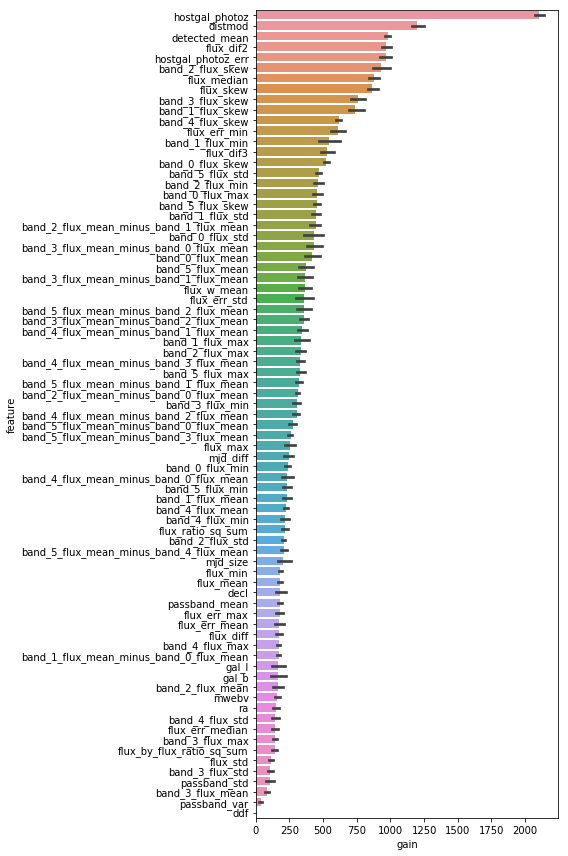

In [9]:
gc.enable()
create_logger()
try:
    main()
except Exception:
    get_logger().exception('Unexpected Exception Occured')
    raise